In [1]:
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
import numpy as np
import pickle
from joblib import Parallel, delayed
from math import log2, ceil
# import ardent
# from scipy.ndimage import zoom
import time
import os
import pandas as pd

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from proglearn.sims import generate_gaussian_parity

import pandas as pd
import SimpleITK as sitk
from sklearn.neighbors import BallTree
# from skimage.transform import rotate

In [2]:
context = sns.plotting_context(context="talk", font_scale=1)
sns.set_context(context)

In [3]:
def init_forest(max_depth):
    # np.random.seed(1)
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    return progressive_learner, uf

In [4]:
def grid_to_pred(task_pos_reshaped, test_task, xx, yy):
    pred = np.empty((len(test_task), ))

    for i in range(len(test_task)):
        x_ind = np.where(test_task[i,0] <= xx[0,:])[0][0]
        y_ind = np.where(test_task[i,1] <= yy[:,0])[0][0]
        pred[i] = task_pos_reshaped[y_ind, x_ind]

    pred = pred.reshape((-1,1))
    pred = np.hstack((pred, 1-pred))
    pred = np.argmax(pred, axis=1)
    
    return pred

In [5]:
def to_grid_in_cir(test_task1, test_task2):
    h = 0.01
    x_min1, x_max1 = test_task1[:,0].min(), test_task1[:,0].max()
    y_min1, y_max1 = test_task1[:,1].min(), test_task1[:,1].max()
    x_min2, x_max2 = test_task2[:,0].min(), test_task2[:,0].max()
    y_min2, y_max2 = test_task2[:,1].min(), test_task2[:,1].max()

    x_min = min(x_min1, x_min2) - 0.1
    x_max = max(x_max1, x_max2) + 0.1
    y_min = min(y_min1, y_min2) - 0.1
    y_max = max(y_max1, y_max2) + 0.1
    x, y = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    r = np.sqrt(x**2 + y**2)  # centered at (0,0)
    inside = r <= 1  # radius of 1
    x_cir = x[inside]  # can also use np.ma.masked_less_equal(r,1).data
    y_cir = y[inside]
    return x, y, inside, np.array([x_cir, y_cir]).T

In [5]:
# def to_grid(test_task1, test_task2):
#     h = 0.01
#     x_min1, x_max1 = test_task1[:,0].min(), test_task1[:,0].max()
#     y_min1, y_max1 = test_task1[:,1].min(), test_task1[:,1].max()
#     x_min2, x_max2 = test_task2[:,0].min(), test_task2[:,0].max()
#     y_min2, y_max2 = test_task2[:,1].min(), test_task2[:,1].max()

#     x_min = min(x_min1, x_min2) - 0.1
#     x_max = max(x_max1, x_max2) + 0.1
#     y_min = min(y_min1, y_min2) - 0.1
#     y_max = max(y_max1, y_max2) + 0.1
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#     new_test_task = np.c_[xx.ravel(), yy.ravel()]
#     return xx, yy, new_test_task

In [6]:
def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

In [7]:
def box_to_cir(data):
    X = data[0]
    y = data[1]
    X_cir = []
    y_cir = []
    for i in range(len(X)):
        if (X[i,0]**2 + X[i,1]**2 <= 1):
            X_cir.append(X[i,:])
            y_cir.append(y[i])
    return np.array(X_cir).reshape(-1,2), np.array(y_cir).reshape(-1)

In [8]:
def generate_posteriors(X, task_id, forest, transformers):
    vote_per_transformer_id = []
    for transformer_id in transformers:
        vote_per_bag_id = []
        for bag_id in range(
            len(forest.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id])
        ):
            transformer = forest.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id][
                bag_id
            ]
            X_transformed = transformer.transform(X)
            voter = forest.task_id_to_decider[task_id].transformer_id_to_voters_[transformer_id][bag_id]
            vote = voter.predict_proba(X_transformed)
            vote_per_bag_id.append(vote)
        vote_per_transformer_id.append(np.mean(vote_per_bag_id, axis=0))

    return vote_per_transformer_id

In [59]:
def run_elastix(task1pred1_reshaped, task2pred2_reshaped, metric, ite):
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(task1pred1_reshaped))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(task2pred2_reshaped))
    elastixImageFilter.LogToFileOn()
    ParamMap = sitk.GetDefaultParameterMap('affine')
#     ParamMap['AutomaticTransformInitialization'] = ['true']
#     ParamMap['AutomaticScalesEstimation'] = ['true']
#     ParamMap['AutomaticTransformInitializationMethod'] = ['GeometricalCenter']
#     ParamMap['Metric'] = [metric]
    
    ParamMap['AutomaticTransformInitialization'] = ['false']
    ParamMap['AutomaticTransformInitializationMethod'] = ['GeometricalCenter']
    ParamMap['Metric'] = [metric]
    ParamMap['MaximumNumberOfIterations'] = [ite]
    ParamMap['MaximumNumberOfSamplingAttempts'] = ['4']
    
    
    # posssibly for 0_60/75/90
# #     ParamMap['AutomaticScalesEstimation'] = ['false']
# #     ParamMap['Scales'] = ['20000.0']
# #     ParamMap['AutomaticTransformInitialization'] = ['true']
#     ParamMap['ImageSampler'] = ['RandomCoordinate']
#     ParamMap['NewSamplesEveryIteration'] = ['true']
#     ParamMap['UseRandomSampleRegion'] = ['true']
#     ParamMap['SampleRegionSize'] = ['100','100']
#     ParamMap['MaximumNumberOfSamplingAttempts'] = ['10']
#     ParamMap['MaximumStepLength'] = ['0.5']
#     ParamMap['AutomaticParameterEstimation'] = ['false']
#     ParamMap['SP_alpha'] = ['0.6']
#     ParamMap['SP_A'] = ['50']
# #     ParamMap['SP_a'] = ['370']
# #     ParamMap['Interpolator'] = ['LinearInterpolator']
# #     ParamMap['FinalBSplineInterpolationOrder'] = ['1']

    # Set the parameter map:
    elastixImageFilter.SetParameterMap(ParamMap)

    # Register the 2D images:
    elastixImageFilter.Execute()

    # Get the registered image:
    RegIm = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
    params = elastixImageFilter.GetTransformParameterMap()[0]["TransformParameters"]
    
    return RegIm, params

In [10]:
def params_to_mat(params):
    init_affines = np.eye(3)
    init_affines[0,:2] = [float(params[0]), float(params[2])]
    init_affines[1,:2] = [float(params[1]), float(params[3])]
    init_affines[2,:2] = [float(params[4]), float(params[5])]
    return init_affines.T

In [10]:
# def exp(n_task1, n_task2, max_depth, n_test=1000, task1_angle=0, task2_angle=np.pi/4, n_trees=10):
#     #source data
#     X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
#     test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)
    
#     #target data
#     X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
#     test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)

#     xx2, yy2, test_task2_grid = to_grid(test_task1, test_task2)
#     errors = np.zeros(7, dtype=float)
    
#     l2f, uf = init_forest(max_depth)
#     l2f.add_task(X_task1, y_task1, num_transformers=n_trees)
#     l2f.add_task(X_task2, y_task2, num_transformers=n_trees)

#     l2f_task1 = generate_posteriors(test_task2_grid, 0, l2f, [0,1])
#     l2f_task2 = generate_posteriors(test_task2_grid, 1, l2f, [0,1])

#     task1pred1_reshaped = l2f_task1[0][:,0].reshape(xx2.shape)
#     task1pred2_reshaped = l2f_task1[1][:,0].reshape(xx2.shape)
#     task2pred1_reshaped = l2f_task2[0][:,0].reshape(xx2.shape)
#     task2pred2_reshaped = l2f_task2[1][:,0].reshape(xx2.shape)

#     vote1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)
#     errors[1] = 1 - np.mean(
#         grid_to_pred(vote1, test_task1, xx2, yy2) == test_label_task1
#     )  # l2f task1 error

# #     vote2 = np.mean([task2pred1_reshaped, task2pred2_reshaped], axis=0)
# #     errors[3] = 1 - np.mean(
# #         grid_to_pred(vote2, test_task2, xx2, yy2) == test_label_task2
# #     )  # l2f task2 error
    
#     # L2F o elastix task1 error
#     task1pred1_deformed, params = run_elastix(
#         task1pred1_reshaped, task2pred2_reshaped, 'AdvancedNormalizedCorrelation', '500'
#     )
#     vote3 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)
#     errors[4] = 1 - np.mean(
#         grid_to_pred(vote3, test_task1, xx2, yy2) == test_label_task1
#     )  

#     # UF
#     uf.add_task(X_task1, y_task1, num_transformers=2*n_trees)
#     uf.add_task(X_task2, y_task2, num_transformers=2*n_trees)

#     uf_task1 = generate_posteriors(test_task2_grid, 0, uf, [0])
#     uf_task2 = generate_posteriors(test_task2_grid, 1, uf, [0])

#     task1pred1_reshaped_uf = uf_task1[0][:,0].reshape(xx2.shape)
#     task2pred1_reshaped_uf = uf_task2[0][:,0].reshape(xx2.shape)

#     errors[0] = 1 - np.mean(
#         grid_to_pred(task1pred1_reshaped_uf, test_task1, xx2, yy2) == test_label_task1
#     )  # uf task1 error
# #     errors[2] = 1 - np.mean(
# #         grid_to_pred(task2pred1_reshaped_uf, test_task2, xx2, yy2) == test_label_task2
# #     )  # uf task2 error

#     return errors

In [11]:
def reshape_posteriors(inside, task):
    inside_ravel = inside.ravel()
    preds = np.zeros(inside_ravel.shape)
    j = 0
    for i in range(len(inside_ravel)):
        if inside_ravel[i]:
            preds[i] = task[j]
            j += 1
    preds = preds.reshape(inside.shape)
    
    return preds

### compute errors

In [12]:
def vote_to_pred(vote, test_task, test_grid):
    tree = BallTree(test_grid)
    pred = np.zeros(test_task.shape)
    for i in range(len(test_task)):
        _, ind = tree.query(test_task[i,:].reshape(-1,2), k=1)
        pred[i,0] = vote[ind]
        pred[i,1] = 1 - pred[i,0]
        
    return pred

In [13]:
def exp(n_task1, n_task2, max_depth, n_test=1000, task1_angle=0, task2_angle=np.pi/4, n_trees=10, ite=500):
    #source data
    X_task1, y_task1 = box_to_cir(generate_gaussian_parity(n_task1, angle_params=task1_angle))
    test_task1, test_label_task1 = box_to_cir(generate_gaussian_parity(n_test, angle_params=task1_angle))

    #target data
    X_task2, y_task2 = box_to_cir(generate_gaussian_parity(n_task2, angle_params=task2_angle))
    test_task2, test_label_task2 = box_to_cir(generate_gaussian_parity(n_test, angle_params=task2_angle))

    xx, yy, inside, test_grid = to_grid_in_cir(test_task1, test_task2)

    l2f, uf = init_forest(max_depth)
    l2f.add_task(X_task1, y_task1, num_transformers=n_trees)
    l2f.add_task(X_task2, y_task2, num_transformers=n_trees)

    l2f_task1 = generate_posteriors(test_grid, 0, l2f, [0,1])
    l2f_task2 = generate_posteriors(test_grid, 1, l2f, [0,1])

    task1pred1_reshaped = reshape_posteriors(inside, l2f_task1[0][:,0])
    task1pred2_reshaped = reshape_posteriors(inside, l2f_task1[1][:,0])
    task2pred1_reshaped = reshape_posteriors(inside, l2f_task2[0][:,0])
    task2pred2_reshaped = reshape_posteriors(inside, l2f_task2[1][:,0])

    uf.add_task(X_task1, y_task1, num_transformers=2*n_trees)
    uf.add_task(X_task2, y_task2, num_transformers=2*n_trees)

    uf_task1 = generate_posteriors(test_grid, 0, uf, [0])
    uf_task2 = generate_posteriors(test_grid, 1, uf, [0])

    task1pred1_reshaped_uf = reshape_posteriors(inside, uf_task1[0][:,0])
#     task2pred1_reshaped_uf = reshape_posteriors(inside, uf_task2[0][:,0])
    
    errors = np.zeros(3, dtype=float)
    vote1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)[inside].ravel()
    pred1 = vote_to_pred(vote1, test_task1, test_grid)
    errors[0] = 1-np.mean(np.argmax(pred1, axis=1) == test_label_task1)
    
    vote3 = task1pred1_reshaped_uf[inside].ravel()
    pred3 = vote_to_pred(vote3, test_task1, test_grid)
    errors[2] = 1-np.mean(np.argmax(pred3, axis=1) == test_label_task1)
    
    try:
        # run elastix
        task1pred1_deformed, params = run_elastix(
                task1pred1_reshaped, task2pred2_reshaped, 'AdvancedNormalizedCorrelation', str(ite)
            )

        vote2 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)[inside].ravel()
        pred2 = vote_to_pred(vote2, test_task1, test_grid)
        errors[1] = 1-np.mean(np.argmax(pred2, axis=1) == test_label_task1)
    except:
        errors[1] = np.nan
    
    return errors

In [60]:
exp(100, 100, ceil(log2(100)), task1_angle=np.pi*(15/180), task2_angle=np.pi*(90/180), ite=1000)

array([0.06586826, 0.25508982, 0.07664671])

In [61]:
n_task1=100; n_task2=100; max_depth=7; n_test=1000; task1_angle=np.pi*(15/180); task2_angle=np.pi*(90/180); n_trees=10

#source data
X_task1, y_task1 = box_to_cir(generate_gaussian_parity(n_task1, angle_params=task1_angle))
test_task1, test_label_task1 = box_to_cir(generate_gaussian_parity(n_test, angle_params=task1_angle))

#target data
X_task2, y_task2 = box_to_cir(generate_gaussian_parity(n_task2, angle_params=task2_angle))
test_task2, test_label_task2 = box_to_cir(generate_gaussian_parity(n_test, angle_params=task2_angle))

xx, yy, inside, test_grid = to_grid_in_cir(test_task1, test_task2)

l2f, uf = init_forest(max_depth)
l2f.add_task(X_task1, y_task1, num_transformers=n_trees)
l2f.add_task(X_task2, y_task2, num_transformers=n_trees)

l2f_task1 = generate_posteriors(test_grid, 0, l2f, [0,1])
l2f_task2 = generate_posteriors(test_grid, 1, l2f, [0,1])

task1pred1_reshaped = reshape_posteriors(inside, l2f_task1[0][:,0])
task1pred2_reshaped = reshape_posteriors(inside, l2f_task1[1][:,0])
task2pred1_reshaped = reshape_posteriors(inside, l2f_task2[0][:,0])
task2pred2_reshaped = reshape_posteriors(inside, l2f_task2[1][:,0])

uf.add_task(X_task1, y_task1, num_transformers=2*n_trees)
uf.add_task(X_task2, y_task2, num_transformers=2*n_trees)

uf_task1 = generate_posteriors(test_grid, 0, uf, [0])
uf_task2 = generate_posteriors(test_grid, 1, uf, [0])

task1pred1_reshaped_uf = reshape_posteriors(inside, uf_task1[0][:,0])

errors = np.zeros(3, dtype=float)
vote1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)[inside].ravel()
pred1 = vote_to_pred(vote1, test_task1, test_grid)
errors[0] = 1-np.mean(np.argmax(pred1, axis=1) == test_label_task1)

vote3 = task1pred1_reshaped_uf[inside].ravel()
pred3 = vote_to_pred(vote3, test_task1, test_grid)
errors[2] = 1-np.mean(np.argmax(pred3, axis=1) == test_label_task1)

In [62]:
# run elastix
task1pred1_deformed, params = run_elastix(
        task1pred1_reshaped, task2pred2_reshaped, 'AdvancedNormalizedCorrelation', '1000'
    )
vote2 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)[inside].ravel()
pred2 = vote_to_pred(vote2, test_task1, test_grid)
errors[1] = 1-np.mean(np.argmax(pred2, axis=1) == test_label_task1)
errors

array([0.07117008, 0.12545235, 0.12545235])

Text(0.5, 1.0, 'deformed')

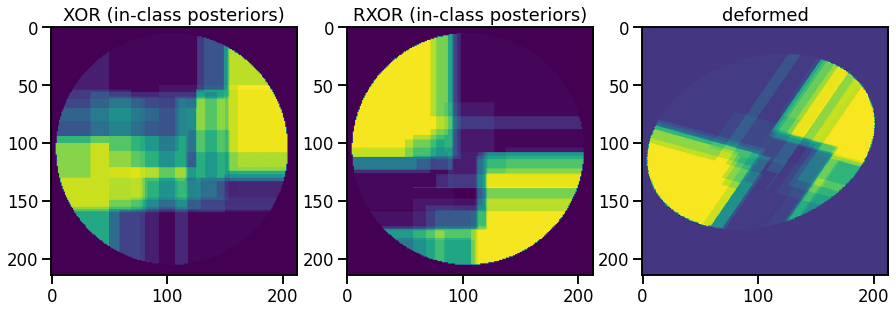

In [63]:
fig,axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(task1pred1_reshaped, vmax=1)
axs[0].set_title("XOR (in-class posteriors)")
axs[1].imshow(task2pred2_reshaped, vmax=1)
axs[1].set_title("RXOR (in-class posteriors)")
axs[2].imshow(task1pred1_deformed, vmax=1)
axs[2].set_title("deformed")

Text(0.5, 1.0, 'test data: RXOR')

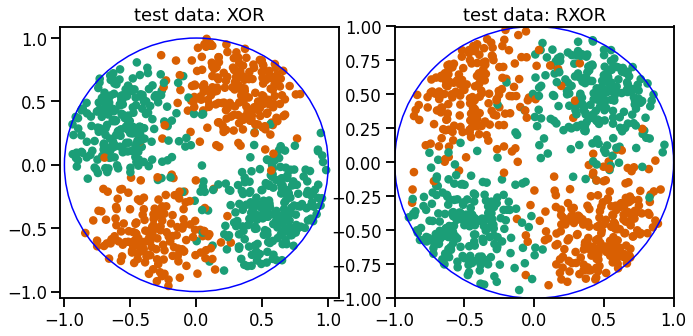

In [64]:
fig,axs = plt.subplots(1,2, figsize=(11,5))
colors = sns.color_palette("Dark2", n_colors=2)
ax = axs[0]
ax.scatter(test_task1[:,0], test_task1[:,1], c=get_colors(colors, test_label_task1), s=50)
circle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(circle)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
ax.set_title("test data: XOR")
ax = axs[1]
ax.scatter(test_task2[:,0], test_task2[:,1], c=get_colors(colors, test_label_task2), s=50)
circle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(circle)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
ax.set_title("test data: RXOR")

In [20]:
start_time = time.time()
print(exp(100,100,7, task1_angle=np.pi*(15/180), task2_angle=np.pi*(65/180), ite=1000))
print("--- %s seconds ---" % (time.time() - start_time))

[0.12702079 0.1108545  0.16281755]
--- 17.538321256637573 seconds ---


In [218]:
rep = 1000
angle1 = 0
angle2 = 60
errors_0_75 = Parallel(n_jobs=-2, verbose=1)(
    delayed(exp)(
        100, 100, ceil(log2(100)), task1_angle=np.pi*(angle1/180), task2_angle=np.pi*(angle2/180), ite=1000
    ) for _ in range(rep)
)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed: 55.2min
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed: 90.6min
[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed: 110.8min finished


In [219]:
[np.mean(np.array(errors_0_75)[:,i]) for i in range(3)]

[0.08744388510357988, 0.07788809503898937, 0.0786937608290182]

In [220]:
for i in [0,1]:
    print(np.mean(np.array(errors_0_75)[:,2]) / np.mean(np.array(errors_0_75)[:,i]))

0.8999344063430291
1.0103438887499498


In [65]:
errors_all_15_simple_param

{'15_105': array([[0.06227967, 0.15041128, 0.09165687],
        [0.13069544, 0.26978417, 0.15707434],
        [0.07728894, 0.18787158, 0.06183115],
        ...,
        [0.07966706, 0.3020214 , 0.08917955],
        [0.06049822, 0.2396204 , 0.08778173],
        [0.07083825, 0.13341204, 0.06847698]])}

In [19]:
# errors_all = {}  ## (errors_all_0_simple_param)
# errors_all_15_simple_param = {}
# errors_all_0_more_param = {}

In [78]:
rep = 1000
angle1 = 15
# angle2 = [0, 15, 30, 45, 60, 75, 90]
angle2 = [15, 30, 45, 60]

for i,a in enumerate(angle2):
    print('angle2 = %s'%a)
    error = np.array(
        Parallel(n_jobs=-3, verbose=1)(
            delayed(exp)(
                100, 100, ceil(log2(100)), task1_angle=np.pi*(angle1/180), 
                task2_angle=np.pi*(a/180), ite=1000
            ) for _ in range(rep)
        )
    )
    name = str(angle1)+"_"+str(a)
    errors_all_15_simple_param[name] = error

angle2 = 15


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  38 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-3)]: Done 188 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-3)]: Done 438 tasks      | elapsed: 47.4min
[Parallel(n_jobs=-3)]: Done 788 tasks      | elapsed: 86.4min
[Parallel(n_jobs=-3)]: Done 1000 out of 1000 | elapsed: 108.9min finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.


angle2 = 30


[Parallel(n_jobs=-3)]: Done  38 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-3)]: Done 188 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-3)]: Done 438 tasks      | elapsed: 48.3min
[Parallel(n_jobs=-3)]: Done 788 tasks      | elapsed: 84.4min
[Parallel(n_jobs=-3)]: Done 1000 out of 1000 | elapsed: 105.2min finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.


angle2 = 45


[Parallel(n_jobs=-3)]: Done  38 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-3)]: Done 188 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-3)]: Done 438 tasks      | elapsed: 50.0min
[Parallel(n_jobs=-3)]: Done 788 tasks      | elapsed: 90.3min
[Parallel(n_jobs=-3)]: Done 1000 out of 1000 | elapsed: 113.6min finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.


angle2 = 60


[Parallel(n_jobs=-3)]: Done  38 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-3)]: Done 188 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-3)]: Done 438 tasks      | elapsed: 43.1min
[Parallel(n_jobs=-3)]: Done 788 tasks      | elapsed: 77.6min
[Parallel(n_jobs=-3)]: Done 1000 out of 1000 | elapsed: 98.2min finished


In [80]:
pickle_out = open("errors_all-sitk-angles15_15_105-simple_ParamMap-0206.pickle", "wb")
pickle.dump(errors_all_15_simple_param, pickle_out)
pickle_out.close()

In [81]:
pickle_in = open("errors_all-sitk-angles15_15_105-simple_ParamMap-0206.pickle", "rb")
i = pickle.load(pickle_in)

### plot data

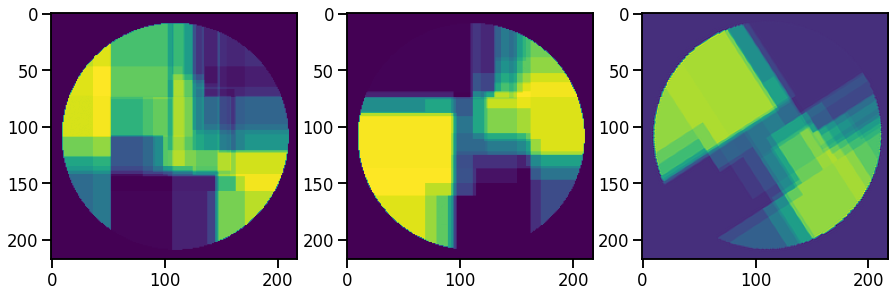

In [122]:
fig,axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(task1pred1_reshaped)
axs[1].imshow(task2pred2_reshaped)
axs[2].imshow(task1pred1_deformed)

(-1.0, 1.0)

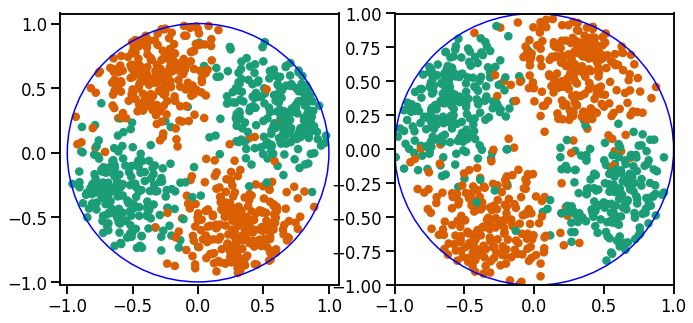

In [128]:
fig,axs = plt.subplots(1,2, figsize=(11,5))
colors = sns.color_palette("Dark2", n_colors=2)
ax = axs[0]
ax.scatter(test_task1[:,0], test_task1[:,1], c=get_colors(colors, test_label_task1), s=50)
circle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(circle)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
ax = axs[1]
ax.scatter(test_task2[:,0], test_task2[:,1], c=get_colors(colors, test_label_task2), s=50)
circle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(circle)
plt.xlim([-1, 1])
plt.ylim([-1, 1])

In [200]:
params_to_mat(params)

array([[ 0.779501 ,  0.622343 , -0.0681927],
       [-0.637417 ,  0.794638 ,  1.21177  ],
       [ 0.       ,  0.       ,  1.       ]])

In [123]:
# j = dat["15_15"]
j = errors_all["15_60"]
[np.mean(j[:,i]) for i in range(3)]

[0.10460220989413642, 0.08891503255868914, 0.09794437340849214]

In [117]:
[np.mean(np.array(errors)[:,i]) for i in range(3)]

[0.10084347903131814, 0.08403340234943373, 0.10077255260377709]

In [124]:
for i in [0,1]:
    print(np.mean(j[:,2]) / np.mean(j[:,i]))

0.9363509003071503
1.1015502169876967


In [96]:
# indices of NaNs
print(np.sum(np.isnan(errors_all_0_simple_param['0_90'])))
errors_all_0_simple_param['0_90_withNans'] = errors_all_0_simple_param['0_90']
errors_all_0_simple_param['0_90'] = errors_all_0_simple_param['0_90_withNans'][~np.isnan(errors_all_0_simple_param['0_90_withNans']).any(axis=1)]


133


In [75]:
# indices of NaNs
print(np.sum(np.isnan(errors_all_15_simple_param['15_105'])))
errors_all_15_simple_param['15_105_withNans'] = errors_all_15_simple_param['15_105']
errors_all_15_simple_param['15_105'] = errors_all_15_simple_param['15_105_withNans'][~np.isnan(errors_all_15_simple_param['15_105_withNans']).any(axis=1)]


146


In [100]:
angle_sweep = [15,30,45,60,75,90,105]
mean_te = np.empty((len(angle_sweep), 2))
for idx in range(len(angle_sweep)):
    name = "15_" + str(angle_sweep[idx])
    j = errors_all_15_simple_param[name]
    mean_te[idx, 0] = np.mean(j[:,2]) / np.mean(j[:,0])
    mean_te[idx, 1] = np.mean(j[:,2]) / np.mean(j[:,1])
    
print(mean_te)

[[1.22777329 1.13718796]
 [0.99049883 1.07500227]
 [0.89695205 1.04826982]
 [0.93520996 1.10375423]
 [1.03098083 1.13743963]
 [1.2607042  0.90105002]
 [1.22828174 0.45928886]]


In [97]:
angle_sweep = [0,15,30,45,60,75,90]
mean_te = np.empty((len(angle_sweep), 2))
for idx in range(len(angle_sweep)):
    name = "0_" + str(angle_sweep[idx])
    j = errors_all_0_simple_param[name]
    mean_te[idx, 0] = np.mean(j[:,2]) / np.mean(j[:,0])
    mean_te[idx, 1] = np.mean(j[:,2]) / np.mean(j[:,1])
    
print(mean_te)

[[1.20358866 1.1329227 ]
 [1.02811112 1.05407534]
 [0.92364046 1.0293382 ]
 [0.88338535 0.98165904]
 [0.91465349 1.02325509]
 [1.03880425 0.78531835]
 [1.19111625 0.4300705 ]]


In [435]:
angle_sweep = [15,30,45,60,75]
mean_te = np.empty((len(angle_sweep), 2))
for idx in range(len(angle_sweep)):
    name = "15_" + str(angle_sweep[idx])
    j = errors_all15[name]
    mean_te[idx, 0] = np.mean(j[:,2]) / np.mean(j[:,0])
    mean_te[idx, 1] = np.mean(j[:,2]) / np.mean(j[:,1])
    
print(mean_te)

[[1.21956223 1.14717485]
 [0.98868568 1.06386821]
 [0.88533327 1.05433797]
 [0.92873233 1.102213  ]
 [1.02614865 1.12458873]]


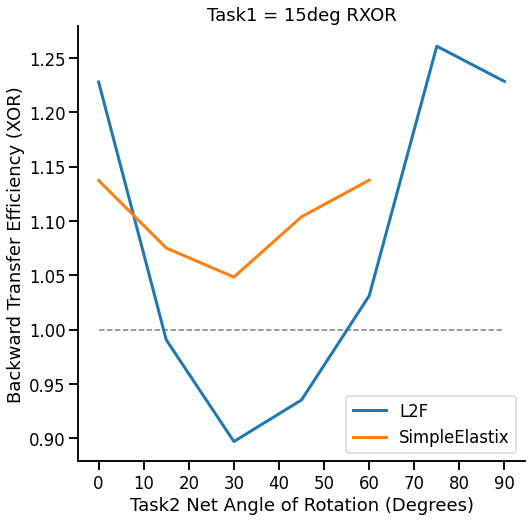

In [101]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
colors = sns.color_palette("Dark2", n_colors=2)
ax.plot(np.array(angle_sweep)-15, mean_te[:,0], linewidth = 3, label="L2F")
ax.plot(np.array(angle_sweep[:-2])-15, mean_te[:-2,1], linewidth = 3, label="SimpleElastix")
ax.set_xticks(range(0,91,10))
ax.set_xlabel('Task2 Net Angle of Rotation (Degrees)')
ax.set_ylabel('Backward Transfer Efficiency (XOR)')
ax.hlines(1, 0,90, colors='gray', linestyles='dashed',linewidth=1.5)
plt.legend()
plt.title('Task1 = 15deg RXOR')
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

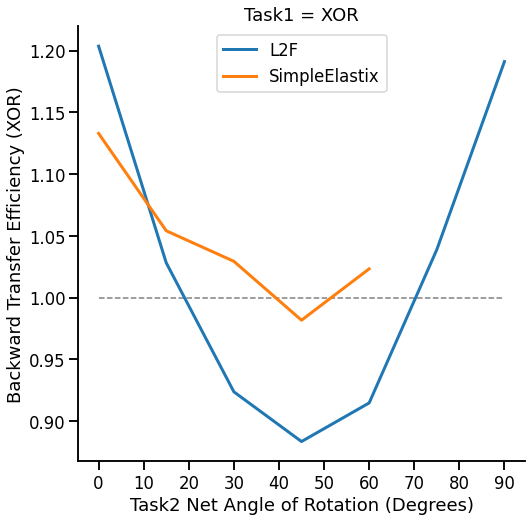

In [98]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
colors = sns.color_palette("Dark2", n_colors=2)
ax.plot(np.array(angle_sweep), mean_te[:,0], linewidth = 3, label="L2F")
ax.plot(np.array(angle_sweep[:-2]), mean_te[:-2,1], linewidth = 3, label="SimpleElastix")
ax.set_xticks(range(0,91,10))
ax.set_xlabel('Task2 Net Angle of Rotation (Degrees)')
ax.set_ylabel('Backward Transfer Efficiency (XOR)')
ax.hlines(1, 0,90, colors='gray', linestyles='dashed',linewidth=1.5)
plt.legend()
plt.title("Task1 = XOR")
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

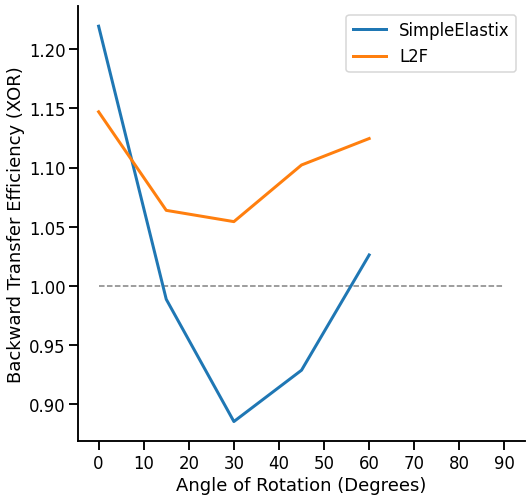

In [436]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
colors = sns.color_palette("Dark2", n_colors=2)
ax.plot(np.array(angle_sweep)-15, mean_te[:,0], linewidth = 3, label="SimpleElastix")
ax.plot(np.array(angle_sweep)-15, mean_te[:,1], linewidth = 3, label="L2F")
ax.set_xticks(range(0,91,10))
ax.set_xlabel('Angle of Rotation (Degrees)')
ax.set_ylabel('Backward Transfer Efficiency (XOR)')
ax.hlines(1, 0,90, colors='gray', linestyles='dashed',linewidth=1.5)
plt.legend()
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

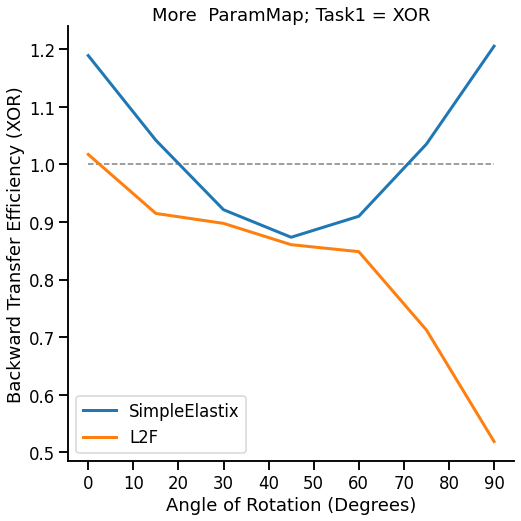

In [58]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
colors = sns.color_palette("Dark2", n_colors=2)
ax.plot(np.array(angle_sweep), mean_te[:,0], linewidth = 3, label="SimpleElastix")
ax.plot(np.array(angle_sweep), mean_te[:,1], linewidth = 3, label="L2F")
ax.set_xticks(range(0,91,10))
ax.set_xlabel('Angle of Rotation (Degrees)')
ax.set_ylabel('Backward Transfer Efficiency (XOR)')
ax.hlines(1, 0,90, colors='gray', linestyles='dashed',linewidth=1.5)
plt.legend()
plt.title("More  ParamMap; Task1 = XOR")
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

In [415]:
pickle_in = open("errors_all-sitk1.pickle", "rb")
i = pickle.load(pickle_in)

In [424]:
errors_all15 = i